In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
μReLU = [0.398942, 
         0.5, 
         0.398942, 
         0., 
         -0.398942, 
         0.]
Eσ2ReLU = .5

μELU = [0.1605205722667549, 
        0.7615782918644975, 
        0.26157829186526865,
        -0.1373639885354897,
        -0.1373639885357776,
        0.2615782918541118]
Eσ2ELU = 0.6449454174923381

def G(z,ηℓ):
    """
    Stieltjes transformation of the MP distribution with ratio ηℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    ηℓ: double
        ratio of the MP distribution
    """
    if(z<0):
        res = (1 - z - ηℓ - np.sqrt((1- z - ηℓ)**2 - 4*ηℓ*z))/(2*z*ηℓ)
    else:
        res = 0
    return res

def dG(z,ηℓ):
    """
    Derivative of the Stieltjes transformation of the MP distribution with ratio ηℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    ηℓ: double
        ratio of the MP distribution
    """
    if(z<0):
        res = (-z*(1 + ηℓ) + (ηℓ - 1)*(-1 + ηℓ + np.sqrt((z - 1)**2 - 2*(1 + z)*ηℓ + ηℓ**2)))/(2*ηℓ*z**2*np.sqrt(-4*ηℓ + (1 - z + ηℓ)**2))
    else:
        res = 0
    return res

def saddle(N,P,L,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs
    
    Parameters:
    -----------
    N : int
        number of random features
    P : int
        size of the training set
    L : int
        truncation of the activation function
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hq_old = 5*np.random.rand(L)
        hχ_old = 5*np.random.rand(L)
        hq0_old, hχ0_old = 5*np.random.rand(2)
        hm_old = 5*np.random.rand(L)
    else :
        hq_old,hχ_old,hm_old,hq0_old,hχ0_old,q_old,χ_old,m_old,q0_old,χ0_old,m0_old,Eg_old = saddle(N,P,L,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
    
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum())
    
    η = np.array([N/math.comb(D,l) for l in range(1,L+1)])
    γ = η*np.reciprocal(hχ_old)*(ζ + hχ0_old)
    
    χ = np.array([η[l]*(1 - γ[l]*G(-γ[l],η[l]))/hχ_old[l] for l in range(0,L)])
    χ0 = (1 - np.array([1 - γ[l]*G(-γ[l],η[l]) for l in range(0,L)]).sum())/(hχ0_old+ζ)
    q = np.array([η[l]*hq0_old/((ζ + hχ0_old)*hχ_old[l])*(γ[l]*G(-γ[l],η[l]) - γ[l]**2*dG(-γ[l],η[l])) + η[l]*(hm_old[l]**2 + hq_old[l])/(hχ_old[l]**2)*(1 + γ[l]**2*dG(-γ[l],η[l]) - 2*γ[l]*G(-γ[l],η[l])) for l in range(0,L)])
    q0 = hq0_old/(ζ + hχ0_old)**2*(1 - np.array([1 - γ[l]**2*dG(-γ[l],η[l]) for l in range(0,L)]).sum())  + np.array([(hm_old[l]**2 + hq_old[l])/(hχ_old[l]*(ζ+hχ0_old))*(γ[l]*G(-γ[l],η[l]) - γ[l]**2*dG(-γ[l],η[l])) for l in range(0,L)]).sum()
    m = χ*hm_old
    m0 = y/μ0
    
    χStar = μPerp**2*χ0 + np.array([χ[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    qStar = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    mStar = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,L)]).sum()
    
    hχ = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/(np.math.factorial(l+1)*(1+χStar)) for l in range(0,L)]) ) + (1-rate)*hχ_old
    hχ0 = rate*(P/N*μPerp**2/(1+χStar)) + (1-rate)*hχ0_old
    hq = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/np.math.factorial(l+1)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2 for l in range(0,L)]) ) + (1-rate)*hq_old
    hq0 = rate*(P/N*μPerp**2*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2) + (1-rate)*hq0_old
    hm = rate*(np.array([P/math.comb(D,l+1)*μ[l]*τ[l+1]/np.sqrt(np.math.factorial(l+1))*yν/(1+χStar) for l in range(0,L)])) + (1-rate)*hm_old
    
    Eg = 1/math.pi*np.arccos(mStar/np.sqrt(qStar))
    
    return hq,hχ,hm,hq0,hχ0,q,χ,m,q0,χ0,m0,Eg

def saddleAsymptI(P,K,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs, asymptotic limit N > P
    
    Parameters:
    -----------
    P : int
        size of the training set
    K : int
        order of log P / log D
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hmK_old,hqK_old,hχK_old = 5*np.random.rand(3)
    else :
        hq_old,hχ_old,hm_old,hq0_old,hχ0_old,q_old,χ_old,m_old,q0_old,χ0_old,m0_old,Eg_old = saddleAsymptI(P,K,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
        hmK_old = hm_old[-1]
        hqK_old = hq_old[-1]
        hχK_old = hχ_old[-1]
        
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,K)]).sum())
    
    χK = 1/(hχK_old + ζ)
    χ = np.zeros(K-1)
    χ = np.append(χ,χK)
    χ0 = 1/ζ
    qK = (hmK_old**2 + hqK_old)/(hχK_old + ζ)**2
    q = np.array([np.math.factorial(l+1)*τ[l+1]**2/(μ[l]**2)*yν**2 for l in range(0,K-1)])
    q = np.append(q,qK)
    q0 = 0
    mK = np.sqrt(np.math.factorial(K))*τ[K]/μ[K-1]*yν*(1-ζ*χK)
    m = np.array([np.sqrt(np.math.factorial(l+1))*τ[l+1]/μ[l]*yν for l in range(0,K-1)])
    m = np.append(m,mK)
    m0 = y/μ0
    
    χStar = μPerp**2*χ0 + np.array([χ[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,K)]).sum()
    qStar = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,K)]).sum()
    mStar = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,K)]).sum()
    
    hχK = rate*(P/(math.comb(D,K)*np.math.factorial(K))*μ[K-1]**2/(1+χStar) ) + (1 - rate)*hχK_old
    hχ = np.full(K-1,np.inf)
    hχ = np.append(hχ,hχK)
    hχ0 = 0
    hqK = rate*( P/math.comb(D,K)*μ[K-1]**2/np.math.factorial(K)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2) + (1-rate)*hqK_old
    hq = np.full(K-1,np.inf)
    hq = np.append(hq,hqK)
    hq0 = 0
    hmK = rate*(P/math.comb(D,K)*μ[K-1]*τ[K]/np.sqrt(np.math.factorial(K))*yν/(1+χStar)) + (1-rate)*hmK_old
    hm = np.full(K-1,np.inf)
    hm = np.append(hm,hmK)
    
    Eg = 1/math.pi*np.arccos(mStar/np.sqrt(qStar))
    
    return hq,hχ,hm,hq0,hχ0,q,χ,m,q0,χ0,m0,Eg


def saddleAsymptII(N,P,L,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs, asymptotic limit N ~ P
    
    Parameters:
    -----------
    N : int
        number of random features
    P : int
        size of the training set
    L : int
        truncation of the activation function
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hq0_old,hχ0_old,hmL_old,hqL_old,hχL_old = 10*np.random.rand(5)
    else :
        hq_old,hχ_old,hm_old,hq0_old,hχ0_old,q_old,χ_old,m_old,q0_old,χ0_old,m0_old,Eg_old = saddleAsymptII(N,P,L,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
        hmL_old = hm_old[-1]
        hqL_old = hq_old[-1]
        hχL_old = hχ_old[-1]
        
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum())
    
    ηL = N/math.comb(D,L)
    γL = ηL/(hχL_old)*(ζ + hχ0_old)
    
    χL = ηL*(1 - γL*G(-γL,ηL))/hχL_old
    χ = np.zeros(L-1)
    χ = np.append(χ,χL)
    χ0 = γL*G(-γL,ηL)/(hχ0_old + ζ)
    qL = ηL*(hq0_old)/((ζ + hχ0_old)*hχL_old)*(γL*G(-γL,ηL)  - γL**2*dG(-γL,ηL)) + ηL*(hmL_old**2 + hqL_old)/(hχL_old**2)*(1 + γL**2*dG(-γL,ηL) - 2*γL*G(-γL,ηL) )
    q = np.array([np.math.factorial(l+1)*τ[l+1]**2/(μ[l]**2)*yν**2 for l in range(0,L-1)])
    q = np.append(q,qL)
    q0 = (hq0_old)/((ζ + hχ0_old)**2 )*γL**2*dG(-γL,ηL) + (hmL_old**2 + hqL_old)/(hχL_old*(hχ0_old+ζ))*( γL*G(-γL,ηL) - γL**2*dG(-γL,ηL))
    mL = χL*hmL_old
    m = np.array([np.sqrt(np.math.factorial(l+1))*τ[l+1]/μ[l]*yν for l in range(0,L-1)])
    m = np.append(m,mL)
    m0 = y/μ0
    
    χStar = μPerp**2*χ0 + np.array([χ[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    qStar = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    mStar = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,L)]).sum()
    
    hχL = rate*(P/(math.comb(D,L)*np.math.factorial(L))*μ[L-1]**2/(1+χStar) ) + (1 - rate)*hχL_old
    hχ = np.full(L-1,np.inf)
    hχ = np.append(hχ,hχL)
    hχ0 = rate*(P/N*μPerp**2/(1+χStar)) + (1 - rate)*hχ0_old
    hqL = rate*(P/math.comb(D,L)*μ[L-1]**2/np.math.factorial(L)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2) + (1-rate)*hqL_old
    hq = np.full(L-1,np.inf)
    hq = np.append(hq,hqL)
    hq0 = rate*(P/N*μPerp**2*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar)/(1+χStar)**2) + (1-rate)*hq0_old
    hmL = rate*(P/math.comb(D,L)*μ[L-1]*τ[L]/np.sqrt(np.math.factorial(L))*yν/(1+χStar)) + (1-rate)*hmL_old
    hm = np.full(L-1,np.inf)
    hm = np.append(hm,hmL)
    
    Eg = 1/math.pi*np.arccos(mStar/np.sqrt(qStar))
    
    return hq,hχ,hm,hq0,hχ0,q,χ,m,q0,χ0,m0,Eg

In [17]:
# Linear teacher, ELU activation, D = 30, N = 10^4

Ps = np.logspace(1,5,100)
maxstep = 1000

Egs = list()
EgsAsI1 = list()
EgsAsI2 = list()
EgsAsI3 = list()
EgsAsII = list()
q0s = list()
q1s = list()
q2s = list()
χ0s = list()
χ1s = list()
χ2s = list()
m0s = list()
m1s = list()
m2s = list()
for p in Ps:
    hq,hχ,hm,hq0,hχ0,q,χ,m,q0,χ0,m0,Eg = saddle(10**4,p,3,np.array([0,1,0,0]),maxstep,rate=.4)
    Egs.append(Eg)
    q0s.append(q0)
    q1s.append(q[0])
    q2s.append(q[1])
    χ0s.append(χ0)
    χ1s.append(χ[0])
    χ2s.append(χ[1])
    m0s.append(m0)
    m1s.append(m[0])
    m2s.append(m[1])
    EgsAsI1.append(saddleAsymptI(p,1,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    EgsAsI2.append(saddleAsymptI(p,2,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    EgsAsI3.append(saddleAsymptI(p,3,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    EgsAsII.append(saddleAsymptII(10**4,p,3,np.array([0,1,0,0]),maxstep,rate=.4)[-1])
    

/tmp/ipykernel_22805/2887572850.py:202: RuntimeWarning: invalid value encountered in arccos
  Eg = 1/math.pi*np.arccos(mStar/np.sqrt(qStar))


In [18]:
PsNum = pd.read_csv("data/eluDATAzeta8.csv")["P"].tolist()
EgsNum = pd.read_csv("data/eluDATAzeta8.csv")["gen"].tolist()
EgsNumErr = np.array(pd.read_csv("data/eluDATAzeta8.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/eluDATAzeta8.csv")["T"].tolist())))

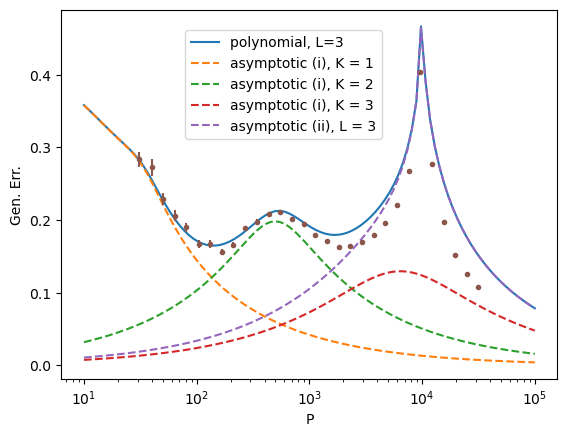

In [27]:
plt.plot(Ps,np.array(Egs),label="polynomial, L=3")
plt.plot(Ps,np.array(EgsAsI1),'--',label="asymptotic (i), K = 1")
plt.plot(Ps,np.array(EgsAsI2),'--',label="asymptotic (i), K = 2")
plt.plot(Ps,np.array(EgsAsI3),'--',label="asymptotic (i), K = 3")
plt.plot(Ps,np.array(EgsAsII),'--',label="asymptotic (ii), L = 3")
plt.errorbar(PsNum,EgsNum,yerr=EgsNumErr,fmt='.')
plt.xscale('log')
plt.xlabel('P')
plt.ylabel('Gen. Err.')
plt.legend(loc=(.25,.65))
plt.show()

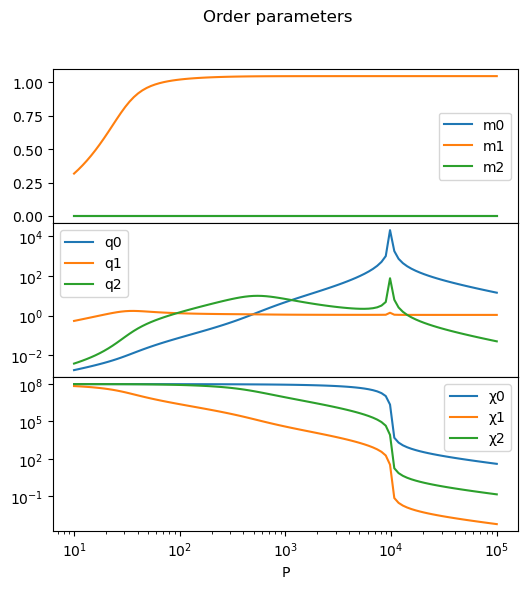

In [28]:
fig,(plM,plQ,plχ) = plt.subplots(3,figsize=(6,6))
plt.subplots_adjust(hspace=0)
fig.suptitle("Order parameters")
plQ.plot(Ps,np.array(q0s),label="q0")
plQ.plot(Ps,np.array(q1s),label="q1")
plQ.plot(Ps,np.array(q2s),label="q2")
plM.plot(Ps,np.array(m0s),label="m0")
plM.plot(Ps,np.array(m1s),label="m1")
plM.plot(Ps,np.array(m2s),label="m2")
plχ.plot(Ps,np.array(χ0s),label="χ0")
plχ.plot(Ps,np.array(χ1s),label="χ1")
plχ.plot(Ps,np.array(χ2s),label="χ2")
plQ.set(xscale='log',yscale='log')
plQ.set_xticks([])
plQ.set_xticks([],minor=True)
plM.set(xscale='log')
plM.set_xticks([])
plM.set_xticks([],minor=True)
plχ.set(xscale='log',yscale='log')
plχ.set_xlabel('P')
plQ.legend()
plM.legend()
plχ.legend()

In [29]:
# Quadratic teacher, ELU activation, D = 30, N = 10^4

Ps = np.logspace(1,5,100)
maxstep = 1000

T2Egs = list()
T2EgsAsI1 = list()
T2EgsAsI2 = list()
T2EgsAsI3 = list()
T2EgsAsII = list()
T2q0s = list()
T2q1s = list()
T2q2s = list()
T2χ0s = list()
T2χ1s = list()
T2χ2s = list()
T2m0s = list()
T2m1s = list()
T2m2s = list()
for p in Ps:
    hq,hχ,hm,hq0,hχ0,q,χ,m,q0,χ0,m0,Eg = saddle(10**4,p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep)
    T2Egs.append(Eg)
    T2q0s.append(q0)
    T2q1s.append(q[0])
    T2q2s.append(q[1])
    T2χ0s.append(χ0)
    T2χ1s.append(χ[0])
    T2χ2s.append(χ[1])
    T2m0s.append(m0)
    T2m1s.append(m[0])
    T2m2s.append(m[1])
    T2EgsAsI1.append(saddleAsymptI(p,1,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])
    T2EgsAsI2.append(saddleAsymptI(p,2,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])
    T2EgsAsI3.append(saddleAsymptI(p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])
    T2EgsAsII.append(saddleAsymptII(10**4,p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-1])

/tmp/ipykernel_22805/2887572850.py:202: RuntimeWarning: invalid value encountered in arccos
  Eg = 1/math.pi*np.arccos(mStar/np.sqrt(qStar))


In [30]:
PsNum2 = pd.read_csv("data/eluDATAzeta8quad.csv")["P"].tolist()
EgsNum2 = pd.read_csv("data/eluDATAzeta8quad.csv")["gen"].tolist()
EgsNumErr2 = np.array(pd.read_csv("data/eluDATAzeta8quad.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/eluDATAzeta8quad.csv")["T"].tolist())))

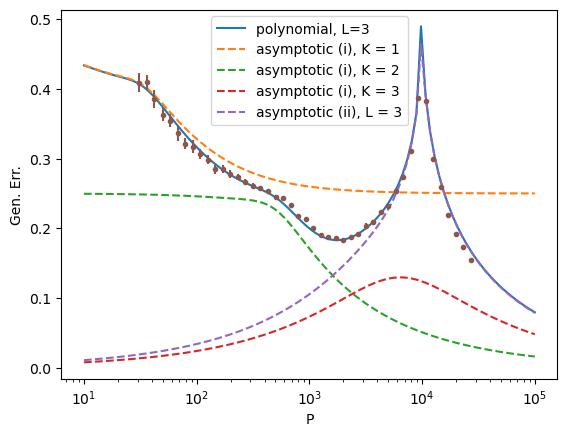

In [31]:
plt.plot(Ps,np.array(T2Egs),label="polynomial, L=3")
plt.plot(Ps,np.array(T2EgsAsI1),'--',label="asymptotic (i), K = 1")
plt.plot(Ps,np.array(T2EgsAsI2),'--',label="asymptotic (i), K = 2")
plt.plot(Ps,np.array(T2EgsAsI3),'--',label="asymptotic (i), K = 3")
plt.plot(Ps,np.array(T2EgsAsII),'--',label="asymptotic (ii), L = 3")
plt.errorbar(PsNum2,EgsNum2,yerr=EgsNumErr2,fmt='.')
plt.xscale('log')
plt.xlabel('P')
plt.ylabel('Gen. Err.')
plt.legend()
plt.show()

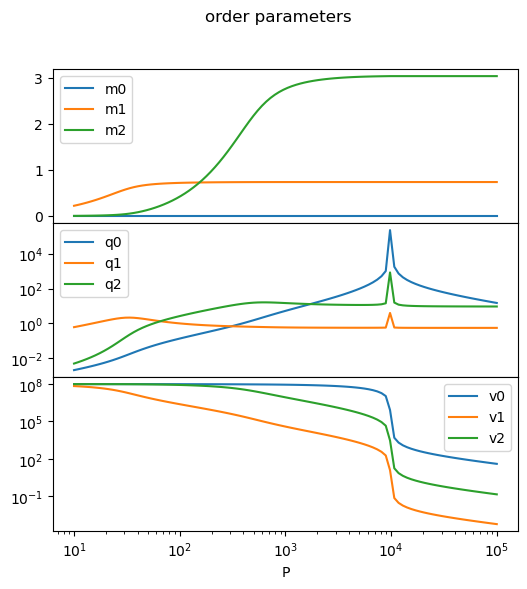

In [33]:
T2fig,(T2plM,T2plQ,T2plχ) = plt.subplots(3,figsize=(6,6))
plt.subplots_adjust(hspace=0)
T2fig.suptitle("order parameters")
T2plQ.plot(Ps,np.array(T2q0s),label="q0")
T2plQ.plot(Ps,np.array(T2q1s),label="q1")
T2plQ.plot(Ps,np.array(T2q2s),label="q2")
T2plM.plot(Ps,np.array(T2m0s),label="m0")
T2plM.plot(Ps,np.array(T2m1s),label="m1")
T2plM.plot(Ps,np.array(T2m2s),label="m2")
T2plχ.plot(Ps,np.array(T2χ0s),label="χ0")
T2plχ.plot(Ps,np.array(T2χ1s),label="χ1")
T2plχ.plot(Ps,np.array(T2χ2s),label="χ2")
T2plQ.set(xscale='log',yscale='log')
T2plQ.set_xticks([])
T2plQ.set_xticks([],minor=True)
T2plM.set(xscale='log')
T2plM.set_xticks([])
T2plM.set_xticks([],minor=True)
T2plχ.set(xscale='log',yscale='log')
T2plχ.set_xlabel('P')
T2plQ.legend()
T2plM.legend()
T2plχ.legend()

In [34]:
# Scaling with D near the peak, linear teacher, ELU activation, α3 = 2.4, P/N = 0.5, N = α3*D^3/3!

Ds = np.logspace(1,3,100)
Ds = list(map(math.floor,Ds))
maxstep = 1000

η3 = 2.4
P_N = .5

T1_varD_Egs = list()
T1_varD_EgsAsII = list()
T1_varD_q0s = list()
T1_varD_q1s = list()
T1_varD_q2s = list()
T1_varD_χ0s = list()
T1_varD_χ1s = list()
T1_varD_χ2s = list()
T1_varD_m0s = list()
T1_varD_m1s = list()
T1_varD_m2s = list()
for d in Ds:
    n = η3*d**3/np.math.factorial(3)
    p = P_N*n
    hq,hχ,hm,hq0,hχ0,q,χ,m,q0,χ0,m0,Eg = saddle(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)
    T1_varD_Egs.append(Eg)
    T1_varD_q0s.append(q0)
    T1_varD_q1s.append(q[0])
    T1_varD_q2s.append(q[1])
    T1_varD_χ0s.append(χ0)
    T1_varD_χ1s.append(χ[0])
    T1_varD_χ2s.append(χ[1])
    T1_varD_m0s.append(m0)
    T1_varD_m1s.append(m[0])
    T1_varD_m2s.append(m[1])
    T1_varD_EgsAsII.append(saddleAsymptII(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)[-1])

In [35]:
# Scaling with D near the peak, linear teacher, ELU activation, α3 = 1, P/N = 0.2, N = α3*D^3/3!

Ds = np.logspace(1,3,100)
Ds = list(map(math.floor,Ds))
maxstep = 1000

η3_2 = 1
P_N_2 = .2

T1_varD2_Egs = list()
T1_varD2_EgsAsII = list()
T1_varD2_q0s = list()
T1_varD2_q1s = list()
T1_varD2_q2s = list()
T1_varD2_χ0s = list()
T1_varD2_χ1s = list()
T1_varD2_χ2s = list()
T1_varD2_m0s = list()
T1_varD2_m1s = list()
T1_varD2_m2s = list()
for d in Ds:
    n = η3_2*d**3/np.math.factorial(3)
    p = P_N_2*n
    hq,hχ,hm,hq0,hχ0,q,χ,m,q0,χ0,m0,Eg = saddle(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)
    T1_varD2_Egs.append(Eg)
    T1_varD2_q0s.append(q0)
    T1_varD2_q1s.append(q[0])
    T1_varD2_q2s.append(q[1])
    T1_varD2_χ0s.append(χ0)
    T1_varD2_χ1s.append(χ[0])
    T1_varD2_χ2s.append(χ[1])
    T1_varD2_m0s.append(m0)
    T1_varD2_m1s.append(m[0])
    T1_varD2_m2s.append(m[1])
    T1_varD2_EgsAsII.append(saddleAsymptII(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)[-1])

In [36]:
varD_DsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["D"].tolist()
varD_PsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["P"].tolist()
varD_NsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["N"].tolist()
varD_EgsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["gen"].tolist()
varD_EgsNumErr = np.array(pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["T"].tolist())))
varD_DsNum_chow = pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["D"].tolist()
varD_EgsNum_chow = pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["gen"].tolist()
varD_EgsNumErr_chow = np.array(pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["T"].tolist())))

varD2_DsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["D"].tolist()
varD2_PsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["P"].tolist()
varD2_NsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["N"].tolist()
varD2_EgsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["gen"].tolist()
varD2_EgsNumErr = np.array(pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["T"].tolist())))

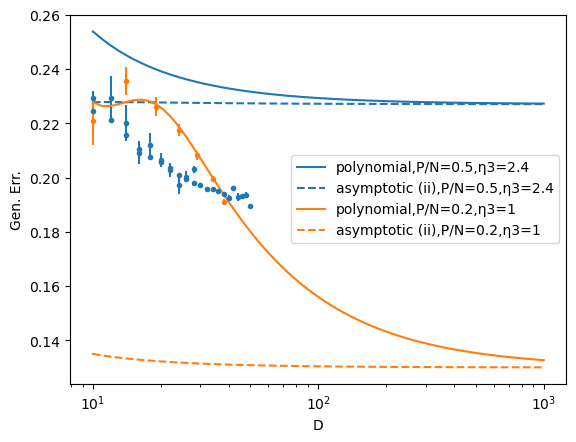

In [37]:
plt.plot(Ds,np.array(T1_varD_Egs),label="polynomial,P/N=0.5,η3=2.4",color="C0")
plt.plot(Ds,np.array(T1_varD_EgsAsII),'--',label="asymptotic (ii),P/N=0.5,η3=2.4",color="C0")
plt.errorbar(varD_DsNum,varD_EgsNum,yerr=varD_EgsNumErr,fmt='.',color="C0")
plt.errorbar(varD_DsNum_chow,varD_EgsNum_chow,yerr=varD_EgsNumErr_chow,fmt='.',color="C0")

plt.plot(Ds,np.array(T1_varD2_Egs),label="polynomial,P/N=0.2,η3=1",color="C1")
plt.plot(Ds,np.array(T1_varD2_EgsAsII),'--',label="asymptotic (ii),P/N=0.2,η3=1",color="C1")
plt.errorbar(varD2_DsNum,varD2_EgsNum,yerr=varD2_EgsNumErr,fmt='.',color="C1")
plt.xscale('log')
plt.xlabel('D')
plt.ylabel('Gen. Err.')
plt.legend()
plt.show()